# 0. IMPORTS

In [60]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

# Data visualization and organisation
import inflection
from tabulate        import tabulate
from IPython.display import Image

# metrics
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics         import confusion_matrix

# feature engineering
from sklearn                 import preprocessing
from scipy.stats             import chi2_contingency
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, LabelEncoder

# pre-modelling
from sklearn.model_selection import train_test_split

# feature selection
from sklearn.ensemble        import RandomForestClassifier

# machine learning models
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neighbors       import KNeighborsClassifier

# Sileting warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/churn.csv')

In [3]:
from IPython.core.display import HTML

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [18, 8]
   plt.rcParams['font.size'] = 20
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )
   sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# For showing percentages in plt.countplot
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()
    
def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [5]:
def cramer_v(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Crosstab building
    chi2 = chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1) 
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [49]:
def ml_performance(model_name, y, yhat):
    accuracy = accuracy_score(y, yhat)
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    roc_auc = roc_auc_score(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name, 
                         'Accuracy': accuracy, 
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1,
                         'AUC ROC': roc_auc}, index = [0])

# 1. DESCRIBE DATA

In [6]:
df1 = df.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
            'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

#CamelCase to snake_case
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data dimensions

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 10000
Number of columns: 14


## 1.3. Data Types

In [15]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4. Check NA

In [17]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Change DataType

In [8]:
df1[['has_cr_card', 'is_active_member', 'exited']] = df1[['has_cr_card', 'is_active_member', 'exited']].astype(bool)
df1[['customer_id', 'row_number']] = df1[['customer_id', 'row_number']].astype('object')

## 1.6. Descriptive Statistics

In [80]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 1.6.1. Numerical Variables

In [30]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.mean()).round(2)
ct2 = pd.DataFrame(num_attributes.median()).round(2)

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std()).round(2)
d2 = pd.DataFrame(num_attributes.min()).round(2)
d3 = pd.DataFrame(num_attributes.max()).round(2)
d4 = pd.DataFrame(num_attributes.max() - num_attributes.min()).round(2)
d5 = pd.DataFrame(num_attributes.skew())
d6 = pd.DataFrame(num_attributes.kurtosis())

# Concatenation
df_num = pd.concat([ct1, ct2, d1, d2, d3, d4, d5, d6], axis = 1)

df_num.columns = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']
df_num

,mean,median,std,min,max,range,skew,kurtosis
credit_score,650.53,652.00,96.65,350.00,850.00,500.00,-0.071607,-0.425726
age,38.92,37.00,10.49,18.00,92.00,74.00,1.011320,1.395347
tenure,5.01,5.00,2.89,0.00,10.00,10.00,0.010991,-1.165225
balance,76485.89,97198.54,62397.41,0.00,250898.09,250898.09,-0.141109,-1.489412
num_of_products,1.53,1.00,0.58,1.00,4.00,3.00,0.745568,0.582981
estimated_salary,100090.24,100193.92,57510.49,11.58,199992.48,199980.90,0.002085,-1.181518


### 1.6.2. Categorical Variables

In [81]:
cat_attributes.head()

,row_number,customer_id,surname,geography,gender,has_cr_card,is_active_member,exited
0,1,15634602,Hargrave,France,Female,True,True,True
1,2,15647311,Hill,Spain,Female,False,True,False
2,3,15619304,Onio,France,Female,True,False,True
3,4,15701354,Boni,France,Female,False,False,False
4,5,15737888,Mitchell,Spain,Female,True,True,False


In [98]:
# # exited
# plt.subplot = (3, 2, 5)
# data = df1.groupby('exited')['customer_id'].count()
# data.plot.pie(autopct = '%.1f%%', subplots = True);

# 2. FEATURE ENGINEERING

In [9]:
df2 = df1.copy()

## 2.1. Hypothesis Mind Map

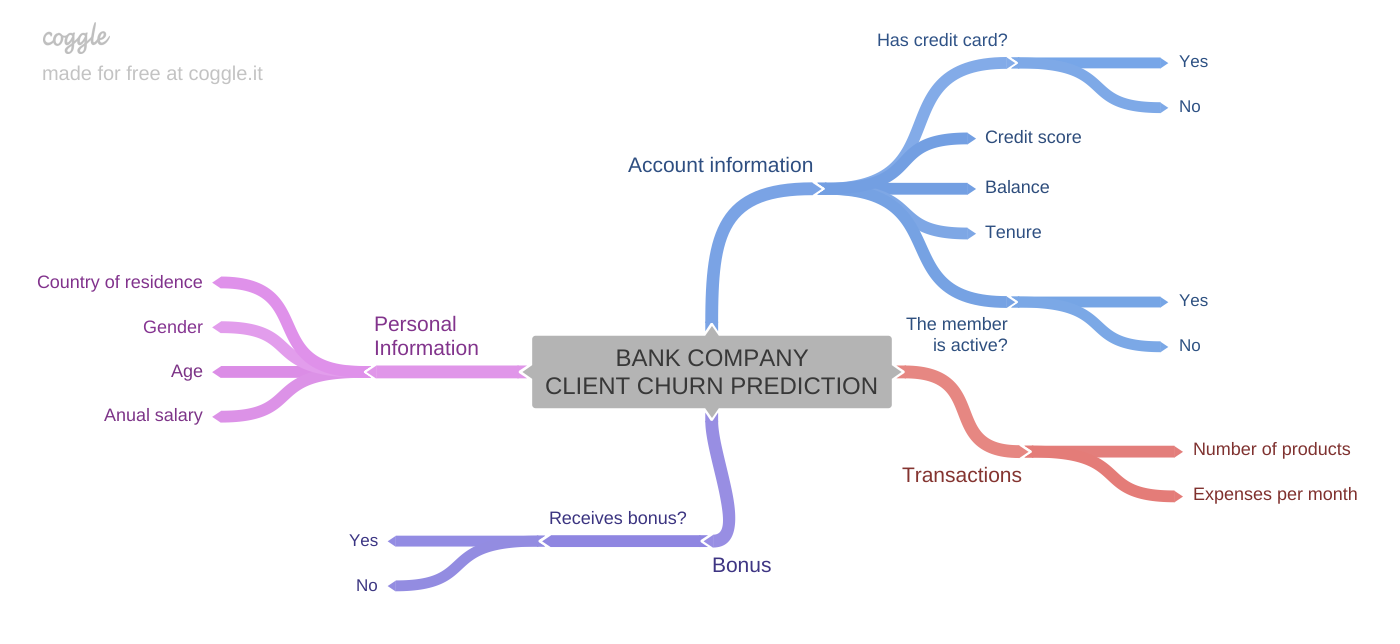

In [176]:
Image(filename = 'img/Hypothesis_MindMap.png')

## 2.2. Hypothesis Development

### 2.2.1. Personal information

**1.** **Younger clients** are **more likely** to churn. <br>
**2.** Churn percentage does not change much between countries in Europe. <br>
**3.** Clients with **higher estimated salary** are **less likely** to churn. <br> 
**4.** There are possibly **no significant differences** between **gender** in churning. <br>

### 2.2.2. Account information

**1.** Clients with **no credit card** are **more likely** to churn. <br>
**2.** Accounts with a **balance of more than 50,000 €** are **less likely** to indicate client churning. <br>
**3.** Accounts who are **active for less than 2 years** are **more likely** to close. <br>
**4.** **Active members** are **less likely** to churn.

### 2.2.3. Transactions

**1.** Clients who **acquired more products** are **less likely** to churn. <br>
**2.** Clients who **spend more than 100 € per month** are **less likely** to churn.

## 2.3. Feature Engineering

### 2.3.1. Modified Columns
(None)

### 2.3.2. Created Columns

In [11]:
# Age group
df2['age_group'] = df2['age'].apply(lambda x: 'young_adult' if x < 40
                                         else 'middle_aged_adult' if x < 60
                                         else 'old')

# Estimated salary group
df2['estimated_salary_group'] = df2['estimated_salary'].apply(lambda x: 'low' if x < 12500
                                                                   else 'medium' if x < 50000
                                                                   else 'high')

# 3. VARIABLE FILTERING

In [12]:
df3 = df2.copy()

## 3.1. Columns Selection

In [13]:
# erase columns 'row_number', 'customer_id', 'customer_surname'
df3 = df3.drop(['row_number', 'customer_id', 'surname'], axis = 1)

# 4. EXPLORATORY DATA ANALYSIS

In [14]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response variable

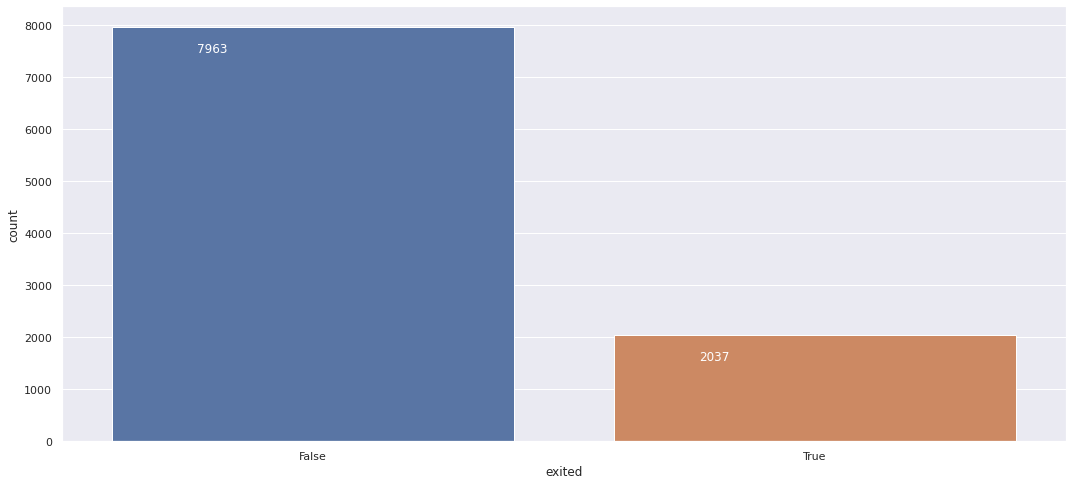

In [93]:
ax = sns.countplot(x = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

In [31]:
print('Percentage of churn clients: {} %'.format(df4[df4['exited'] == True].shape[0] / df4.shape[0] * 100))

Percentage of churn clients: 20.369999999999997 %


### 4.1.2. Numerical variables

In [172]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])

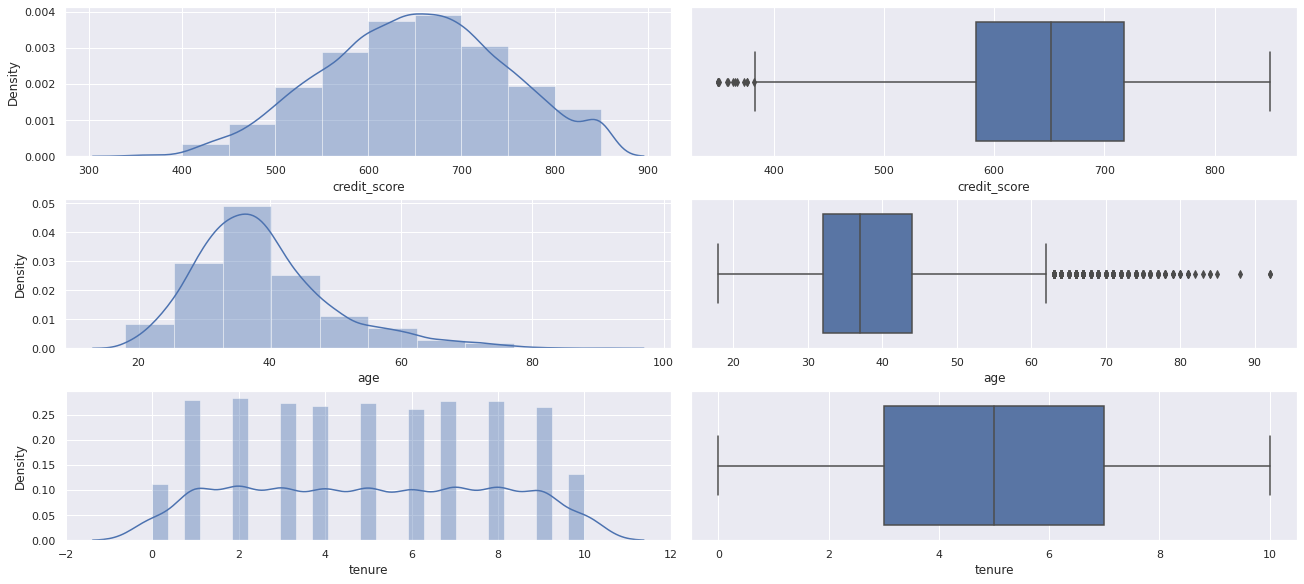

In [54]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

plt.subplot(3, 2, 1)
ax1 = sns.distplot(df4['credit_score'], bins = 10);

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(x = 'credit_score', data = df4);

plt.subplot(3, 2, 3)
ax3 = sns.distplot(df4['age'], bins = 10);

plt.subplot(3, 2, 4)
ax4 = sns.boxplot(x = 'age', data = df4);

plt.subplot(3, 2, 5)
ax5 = sns.distplot(df4['tenure']);

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(x = 'tenure', data = df4);

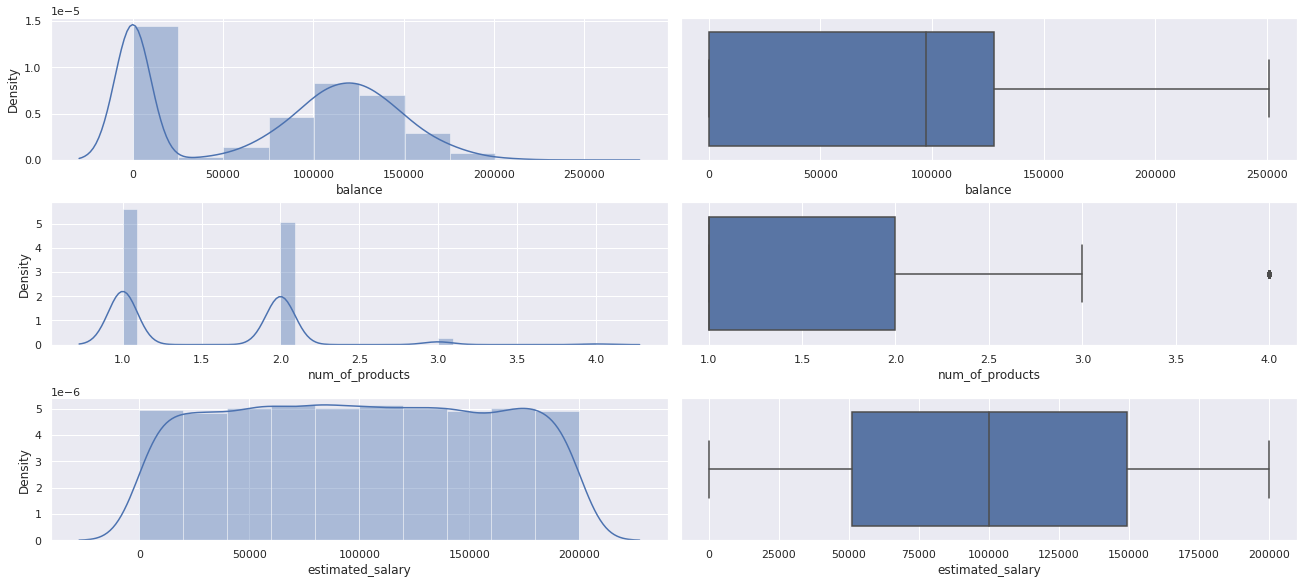

In [55]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

plt.subplot(3, 2, 1)
ax1 = sns.distplot(df4['balance'], bins = 10);

plt.subplot(3, 2, 2)
ax2 = sns.boxplot(x = 'balance', data = df4);

plt.subplot(3, 2, 3)
ax3 = sns.distplot(df4['num_of_products']);

plt.subplot(3, 2, 4)
ax4 = sns.boxplot(x = 'num_of_products', data = df4);

plt.subplot(3, 2, 5)
ax5 = sns.distplot(df4['estimated_salary'], bins = 10);

plt.subplot(3, 2, 6)
ax6 = sns.boxplot(x = 'estimated_salary', data = df4);

### 4.1.3. Categorical variables

In [177]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64'])
cat_attributes = cat_attributes.drop('exited', axis = 1)

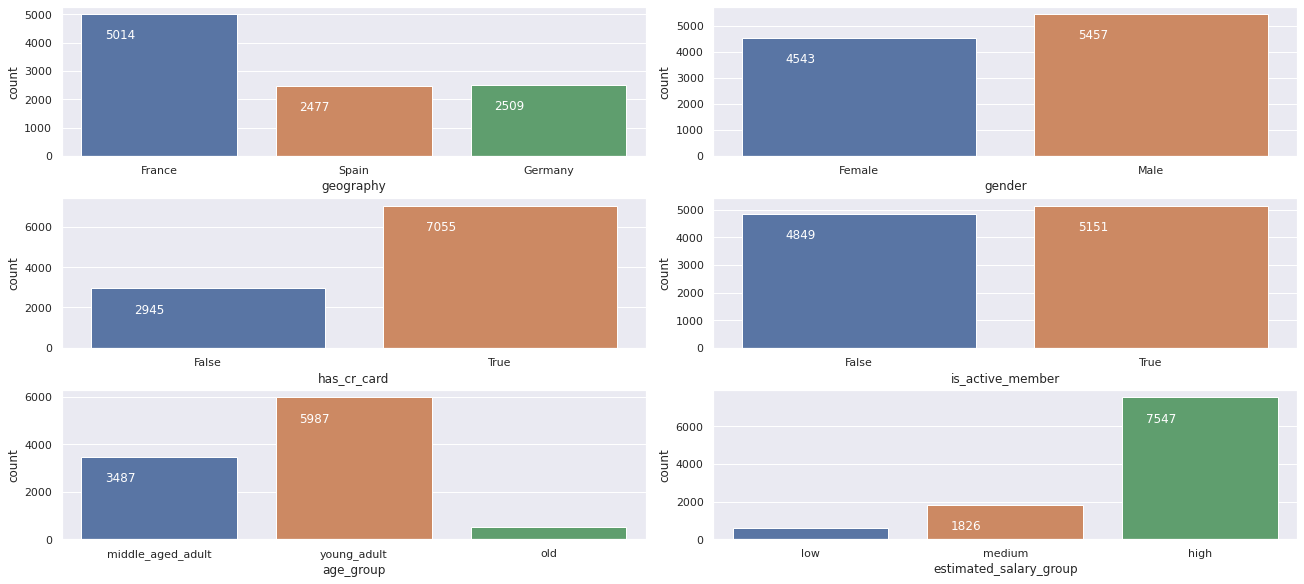

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5)) = plt.subplots(ncols = 2, nrows = 3, constrained_layout = True)

# geography
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x = 'geography', data = df4);
for p in ax1.patches:
    ax1.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# gender
plt.subplot(3, 2, 2)
ax2 = sns.countplot(x = 'gender', data = df4);
for p in ax2.patches:
    ax2.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# has_cr_card
plt.subplot(3, 2, 3)
ax3 = sns.countplot(x = 'has_cr_card', data = df4);
for p in ax3.patches:
    ax3.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

# is_active_member
plt.subplot(3, 2, 4)
ax4 = sns.countplot(x = 'is_active_member', data = df4);
for p in ax4.patches:
    ax4.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

# age_group
plt.subplot(3, 2, 5)
ax5 = sns.countplot(x = 'age_group', data = df4);
for p in ax5.patches:
    ax5.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)
    
# estimated_salary_group
plt.subplot(3, 2, 6)
ax5 = sns.countplot(x = 'estimated_salary_group', data = df4, order = ['low', 'medium', 'high']);
for p in ax5.patches:
    ax5.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

## 4.2. Bivariate Analysis - Hypothesis Validation

### 4.2.1. Individual Analysis of the Hypothesis

**H1.** **Younger clients** are **more likely** to churn. <br>
**FALSE** - Middle-aged clients have a more considerable percentage of churning.

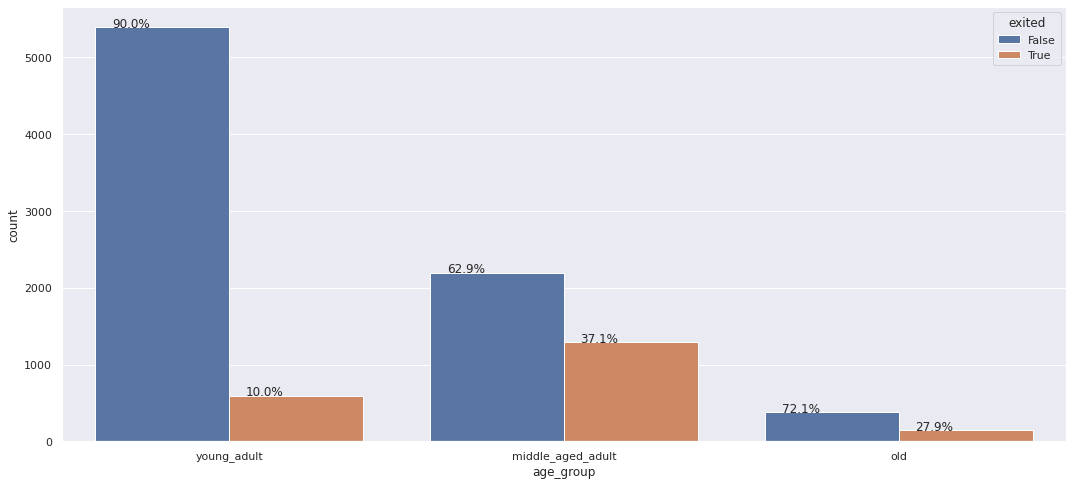

In [117]:
ax = sns.countplot(x = "age_group", hue = 'exited', data = df4, order = ['young_adult', 'middle_aged_adult', 'old']);

with_hue(ax, df4['age_group'], 3, 2)

**H2.** Churn percentage **does not change much** between **countries** in Europe. <br>
**FALSE** - It is observed a similarity in percentage between France and Spain, although Germany has a higher rate of churning.

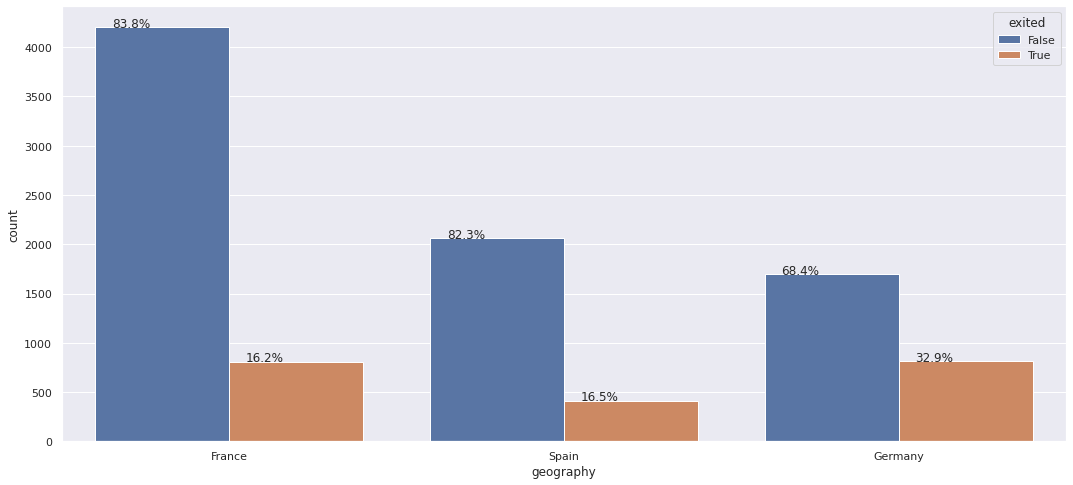

In [88]:
ax = sns.countplot(x = 'geography', hue = 'exited', data = df4);

with_hue(ax, df4['geography'], 3, 2)

**H3.** Clients with **higher estimated salary** are **less likely** to churn. <br>
**FALSE**, although percentage does not change much between categories.

In [43]:
aux1 = df4[df4['exited'] == True]

low_exited = aux1[aux1['estimated_salary_group'] == 'low'].shape[0]
medium_exited = aux1[aux1['estimated_salary_group'] == 'medium'].shape[0]
high_exited = aux1[aux1['estimated_salary_group'] == 'high'].shape[0]

#------------------------------

aux2 = df4[df4['exited'] == False]

low_not_exited = aux2[aux2['estimated_salary_group'] == 'low'].shape[0]
medium_not_exited = aux2[aux2['estimated_salary_group'] == 'medium'].shape[0]
high_not_exited = aux2[aux2['estimated_salary_group'] == 'high'].shape[0]

#------------------------------

print('Churn percentage for low salary range: {} % \n'.format(round(low_exited / (low_exited + low_not_exited)* 100, 2)))
print('Churn percentage for medium salary range: {} % \n'.format(round(medium_exited / (medium_exited + medium_not_exited)* 100, 2)))
print('Churn percentage for high salary range: {} %'.format(round(high_exited / (high_exited + high_not_exited)* 100, 2)))

Churn percentage for low salary range: 18.98 % 

Churn percentage for medium salary range: 20.26 % 

Churn percentage for high salary range: 20.51 %


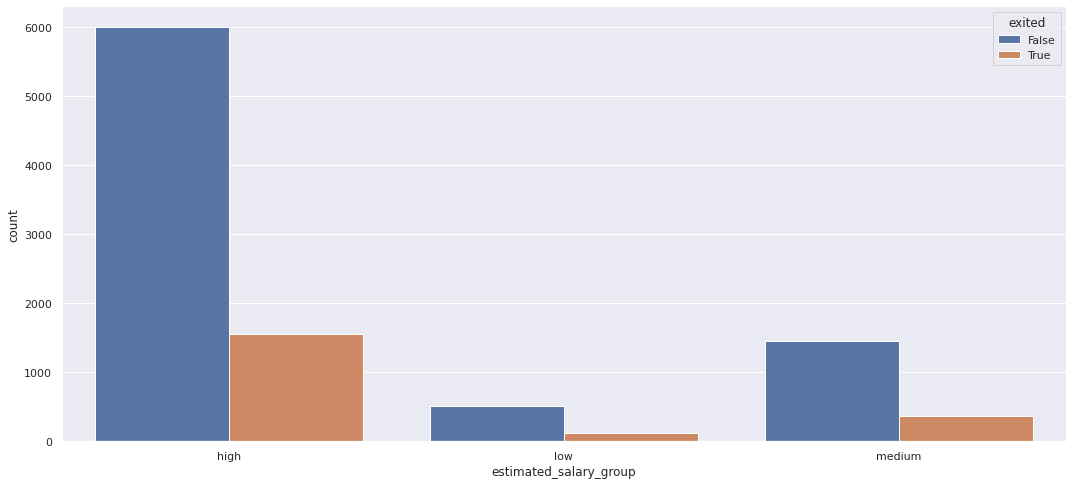

In [45]:
ax = sns.countplot(x = "estimated_salary_group", hue = 'exited', data = df4);

**H4.** There are possibly **no significant differences** between **gender** in churning. <br>
**FALSE** - The churn rate among women is significantly higher (almost 10 % more).

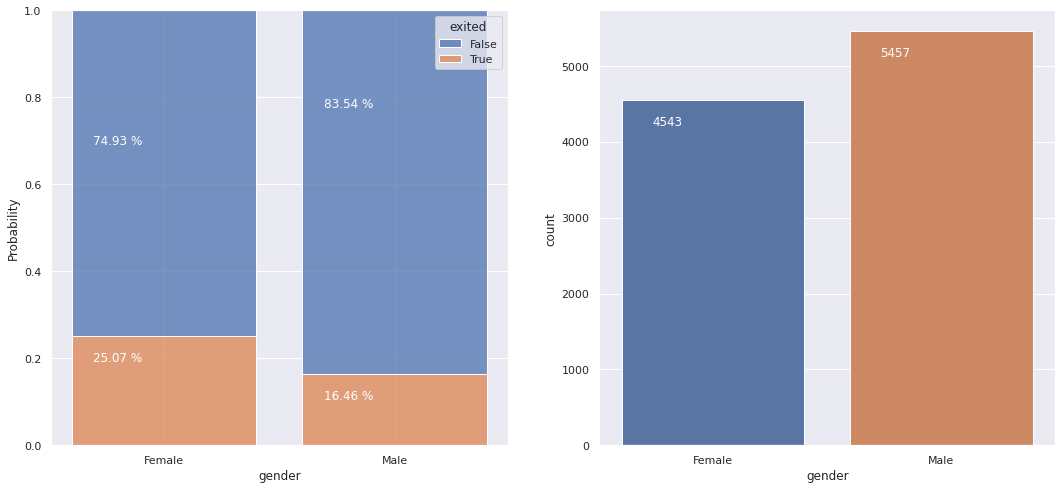

In [143]:
plt.subplot(1, 2, 1)
ax = sns.histplot(df4, x = 'gender', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'gender', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H5.** Clients with **no credit card** are **more likely** to churn. <br>
**TRUE**, although difference is not significant (less than 1 %).

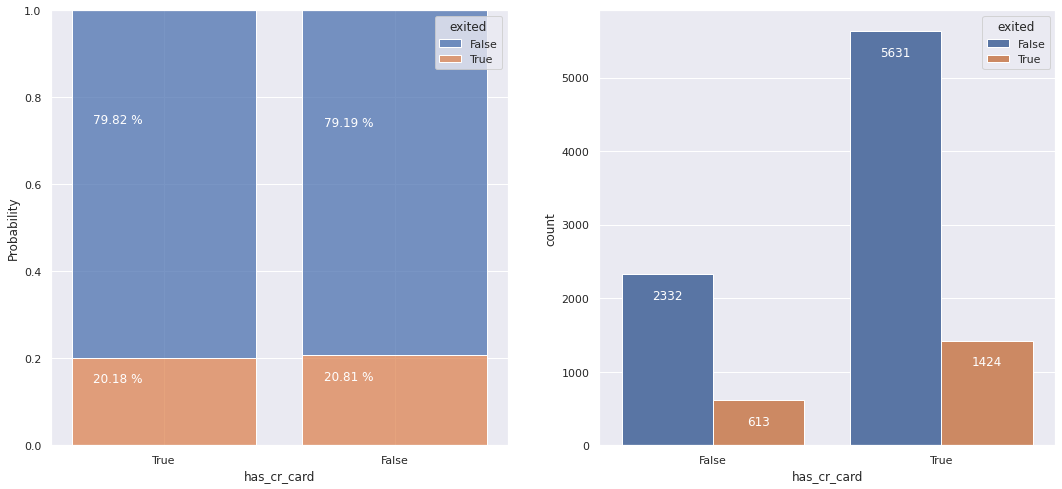

In [145]:
aux = df4.copy()

d = {True: 'True', False: 'False'}
aux['has_cr_card'] = aux['has_cr_card'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'has_cr_card', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'has_cr_card', hue = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H6.** Accounts with a **balance of more than 50,000 €** are **less likely** to indicate client churning. <br>
**FALSE**, and they do represent a significant amount of the exiting clients.

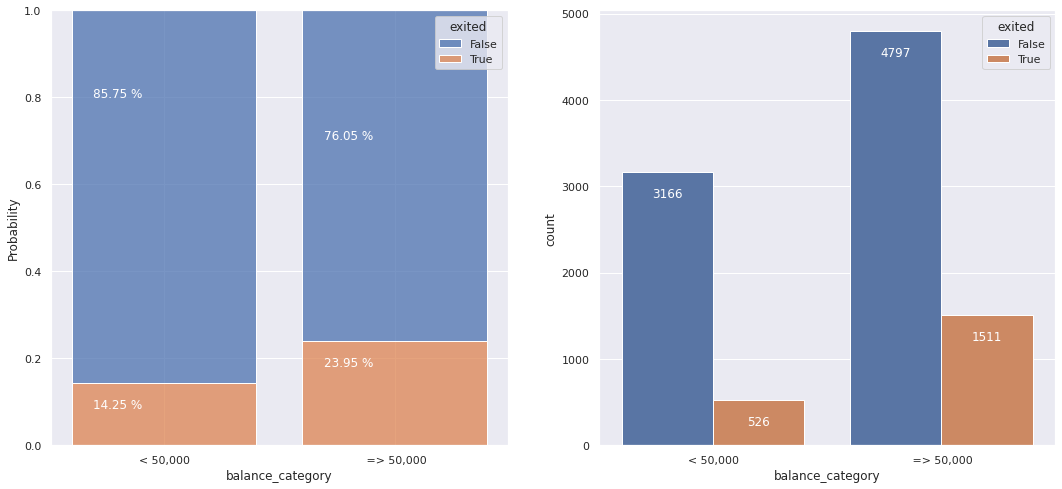

In [146]:
aux = df4.copy()

aux['balance_category'] = aux['balance'].apply(lambda x: '< 50,000' if x < 50000
                                                    else ' => 50,000')

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'balance_category', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'balance_category', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H7.** Accounts who are **active for less than 2 years** are **more likely** to close. <br>
**TRUE**, although percentage difference is not significant (approximately 1 %)

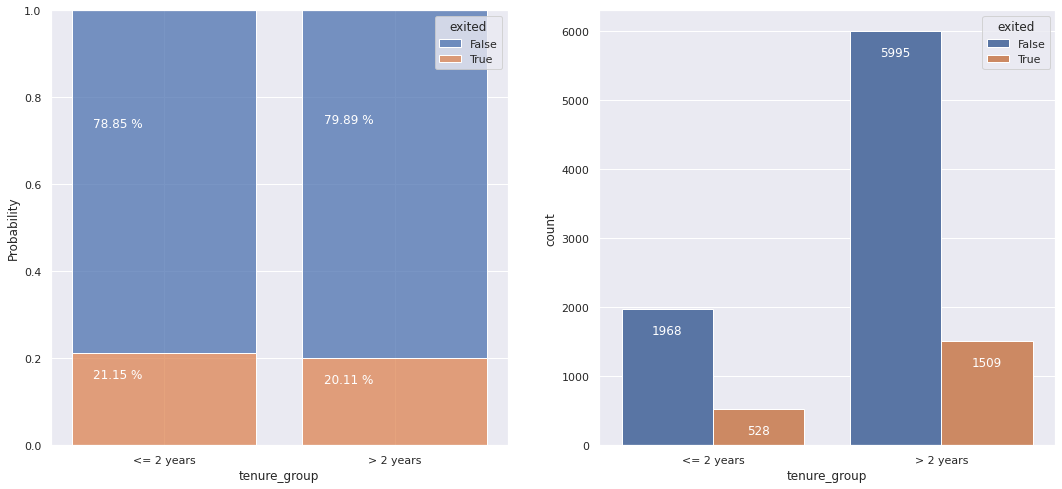

In [147]:
aux = df4.copy()

aux['tenure_group'] = aux['tenure'].apply(lambda x: '<= 2 years' if x <= 2
                                               else '> 2 years')

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'tenure_group', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'tenure_group', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H8.** **Active members** are **less likely** to churn. <br>
**TRUE**, with a percentage difference of about 13 %.

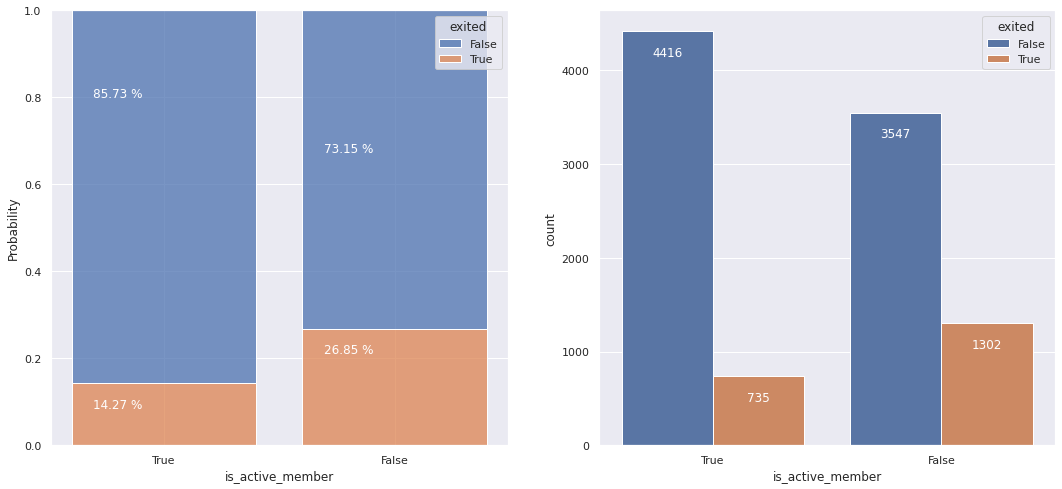

In [148]:
aux = df4.copy()

d = {True: 'True', False: 'False'}
aux['is_active_member'] = aux['is_active_member'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'is_active_member', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'is_active_member', hue = 'exited', data = aux);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 12)

**H9.** Clients who **acquired more products** are **less likely** to churn. <br>
**FALSE**, and the percentage of clients that acquired more than 3 bank products that exited is way higher than the ones that did not exit.

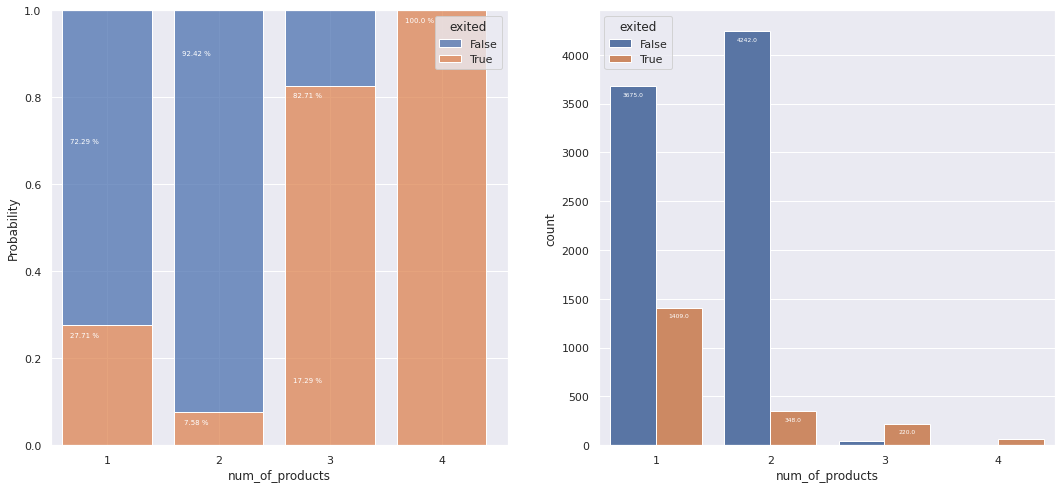

In [166]:
aux = df4.copy()

d = {1: '1', 2: '2', 3: '3', 4: '4'}
aux = aux.sort_values(by = 'num_of_products')
aux['num_of_products'] = aux['num_of_products'].replace(d)

plt.subplot(1, 2, 1)
ax = sns.histplot(aux, x = 'num_of_products', hue = 'exited', stat = 'probability', multiple = 'fill', shrink = .8);
for p in ax.patches:
    ax.annotate(f'\n{round(p.get_height() * 100, 2)} %', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 7)

plt.subplot(1, 2, 2)
ax = sns.countplot(x = 'num_of_products', hue = 'exited', data = df4);
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'top', color = 'white', size = 6)

### 4.2.1. General Hypothesis Review

In [171]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1 - Younger clients are more likely to churn', 'False', 'High'],
       ['H2 - Churn percentage does not change much between countries in Europe', 'False', 'High'],
       ['H3 - Clients with higher estimated salary are less likely to churn', 'False', 'Low'],
       ['H4 - There are possibly no significant differences between gender in churning', 'False', 'Medium'],
       ['H5 -  Clients with no credit card are more likely to churn', 'True', 'Low'],
       ['H6 - Accounts with a balance of more than 50,000 € are less likely to indicate client churning', 'False', 'Medium'],
       ['H7 - Accounts who are active for less than 2 years are more likely to close', 'True', 'Low'],
       ['H8 - Active members are less likely to churn', 'True', 'High'],
       ['H9 - Clients who acquired more products are less likely to churn', 'False', 'High']
      ]
print(tabulate(tab, headers='firstrow'))

Hypothesis                                                                                      Conclusion    Relevance
----------------------------------------------------------------------------------------------  ------------  -----------
H1 - Younger clients are more likely to churn                                                   False         High
H2 - Churn percentage does not change much between countries in Europe                          False         High
H3 - Clients with higher estimated salary are less likely to churn                              False         Low
H4 - There are possibly no significant differences between gender in churning                   False         Medium
H5 -  Clients with no credit card are more likely to churn                                      True          Low
H6 - Accounts with a balance of more than 50,000 € are less likely to indicate client churning  False         Medium
H7 - Accounts who are active for less than 2 years are more likely

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

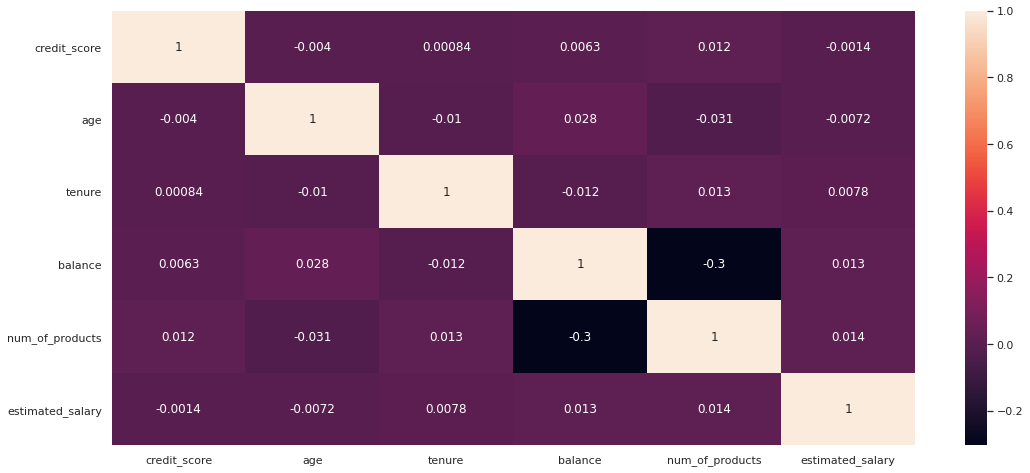

In [173]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Variables

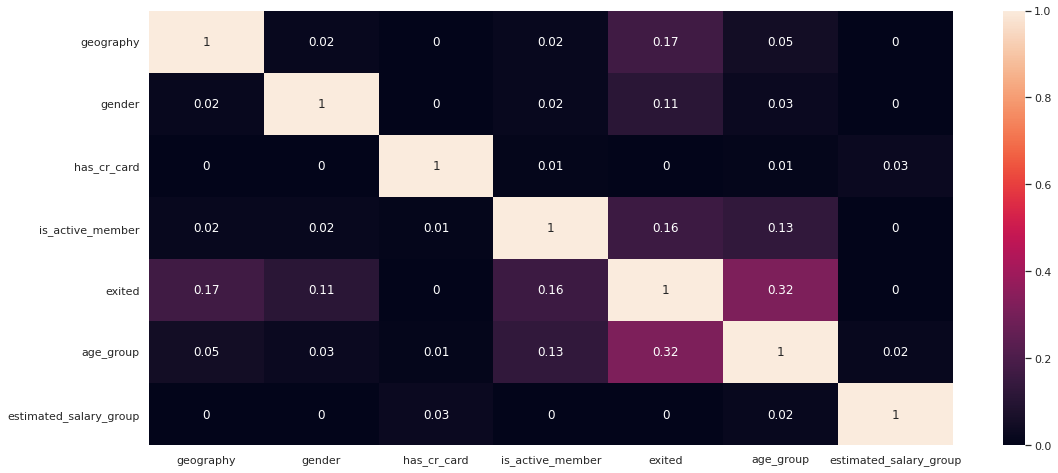

In [186]:
a = df4.select_dtypes(exclude = ['int64', 'float64'])

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in a.columns :
    data_encoded[i] = label.fit_transform(a[i])

rows = []

for var1 in data_encoded:
    col = []
    
    for var2 in data_encoded :
        cramer = cramer_v(data_encoded[var1], data_encoded[var2])
        col.append(round(cramer, 2)) 
    
    rows.append(col)
    
cramer_results = np.array(rows)
d = pd.DataFrame(cramer_results, columns = data_encoded.columns, index = data_encoded.columns)

sns.heatmap(d, annot = True);

# 5. DATA PREPARATION

In [15]:
df5 = df4.copy()

## 5.1. Rescaling

In [19]:
mms = MinMaxScaler()
rs = RobustScaler()

# MinMaxScaler for 'tenure', 'balance', 'num_of_products' & 'estimated_salary'
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
df5['balance'] = mms.fit_transform(df5[['balance']].values)
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)
df5['estimated_salary'] = mms.fit_transform(df5[['estimated_salary']].values)

# RobustScaler for 'credit_score' & 'age' (significant presence of outliers)
df5['credit_score'] = rs.fit_transform(df5[['credit_score']].values)
df5['age'] = rs.fit_transform(df5[['age']].values)

## 5.2. Encoding

In [24]:
# LabelEncoder for 'geography' & 'gender'
le = LabelEncoder()

df5['geography'] = le.fit_transform(df5['geography'])

df5['gender'] = le.fit_transform(df5['gender'])


# OrdinalEncoder for 'age_group' & 'estimated_salary_group'
assort_dict1 = {'young_adult': 1,
                'middle_aged_adult': 2,
                'old': 3}
df5['age_group'] = df5['age_group'].map(assort_dict1)

assort_dict2 = {'low': 1,
                'medium': 2,
                'high': 3}
df5['estimated_salary_group'] = df5['estimated_salary_group'].map(assort_dict2)

# 6. FEATURE SELECTION

In [26]:
df6 = df5.copy()

## 6.1. Split DataFrame into Training and Test

In [29]:
train, test = train_test_split(df6, test_size = 0.2, random_state = 42, shuffle = True)

X_train = train
y_train = X_train['exited']
X_train = X_train.drop(['exited'], axis = 1)

X_test = test
y_test = X_test['exited']
X_test = X_test.drop(['exited'], axis = 1)

## 6.2. RandomForest as Feature Selector

In [32]:
# train RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns, 'feature importance': rf.feature_importances_}).sort_values('feature importance', ascending = False).reset_index(drop = True)

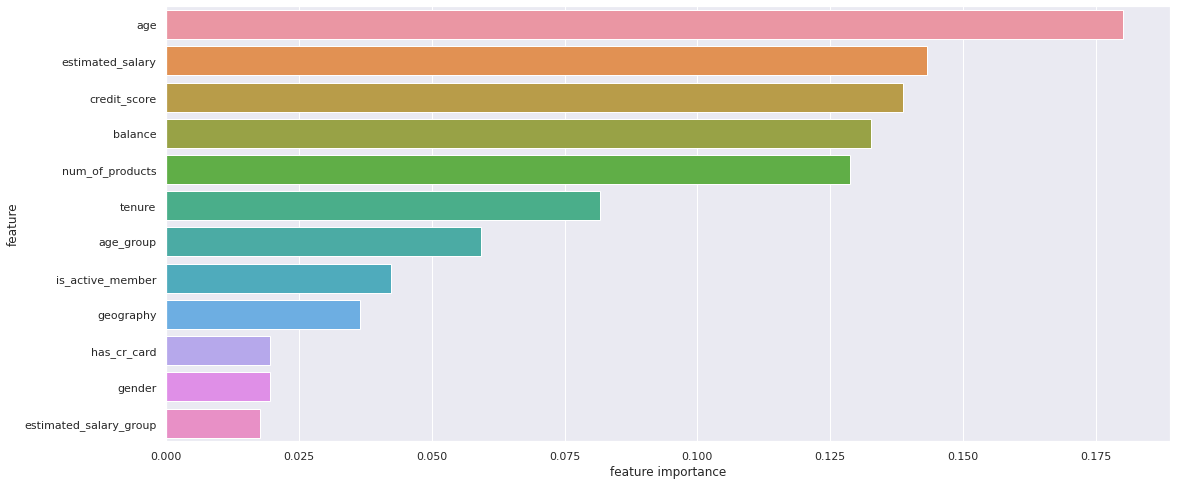

In [35]:
# Plot feature importance
sns.barplot(x = 'feature importance', y = 'feature', data = feat_imp, orient = 'h');

In [40]:
feat_imp_select = feat_imp.iloc[:9]
feat_imp_select

,feature,feature importance
0,age,0.180045
1,estimated_salary,0.143298
2,credit_score,0.138624
3,balance,0.132693
4,num_of_products,0.128801
5,tenure,0.081607
6,age_group,0.059277
7,is_active_member,0.042272
8,geography,0.036505


In [41]:
feat_imp_select['feature'].to_list()

['age',
 'estimated_salary',
 'credit_score',
 'balance',
 'num_of_products',
 'tenure',
 'age_group',
 'is_active_member',
 'geography']

## 6.3. Saving Best Features (Feature selector + EDA)

In [45]:
cols_selected = ['age',
                 'estimated_salary',
                 'credit_score',
                 'balance',
                 'num_of_products',
                 'tenure',
                 'is_active_member',
                 'geography']

# columns to add
feat_to_add = ['gender', 'exited']

# final features
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(feat_to_add)

# 7. MACHINE LEARNING MODELS

In [46]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

In [47]:
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

## 7.1. Logistic Regression

In [52]:
# model
lr = LogisticRegression()
lr.fit(x_train, y_train)

# prediction
y_hat = lr.predict(x_test)

# # performance
lr_result = ml_performance('Logistic Regression', y_test, y_hat)
lr_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Logistic Regression,0.8075,0.536364,0.150127,0.234592,0.559196


## 7.2. SVC

In [54]:
svc = SVC()
svc.fit(x_train, y_train)

y_hat = svc.predict(x_test)

svc_result = ml_performance('Support Vector Classifier', y_test, y_hat)
svc_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Support Vector Classifier,0.8455,0.813433,0.277354,0.413662,0.630898


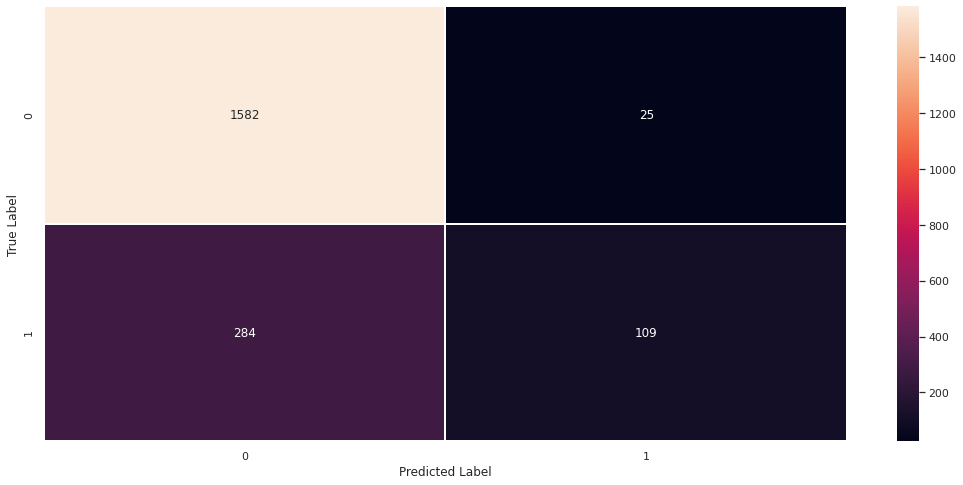

In [56]:
cm = confusion_matrix(y_test, y_hat)

sns.heatmap(cm, fmt = '.0f', annot = True, linewidths = 0.2, linecolor = 'white')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 7.3. RandomForest

In [58]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state = 42)
rf.fit(x_train, y_train)

y_hat = rf.predict(x_test)

rf_result = ml_performance('Random Forest Classifier', y_test, y_hat)
rf_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,Random Forest Classifier,0.865,0.748988,0.470738,0.578125,0.716078


## 7.4. XGBoostClassifier

## 7.5.  KNN Classifier

In [61]:
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', n_jobs = -1)
knn.fit(x_train, y_train)

y_hat = knn.predict(x_test)

knn_result = ml_performance('K-Nearest Neighbors', y_test, y_hat)
knn_result

,Model Name,Accuracy,Precision,Recall,F1 Score,AUC ROC
0,K-Nearest Neighbors,0.8295,0.608333,0.371501,0.461295,0.656504
